In [9]:
import numpy as np
import pandas as pd
import os
import sys
from math import frexp, ldexp
import math
import time
from itertools import permutations, product
from condTE_utils import CondTEUtils as CTU
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# load data
datapath = '../Firearms'
data_original = pd.read_excel(os.path.join(datapath,'summary_data.xlsx'))
BC = data_original['Background checks (48 states, processed)'].values
MS = data_original['Mass shooting'].values
MO = data_original.values[:,2]

# symbolic
XBC = (np.diff(BC,axis=0) > 0) * 1
XMS = (MS[:-1] > 0) * 1
XMO = (np.diff(MO,axis=0) > 0) * 1
Nt = len(XBC)
XBC.shape, XMS.shape, XMO.shape

((227,), (227,), (227,))

## Experiement

In [28]:
data = {'MS': XMS, 'BC': XBC, 'MO': XMO}
con_te_results = {}
for t,s,c in permutations(data.keys(), 3):
    print('calculating.....{}->{}/{}'.format(s, t, c))
    for s_lag, c_lag in product(range(12), range(12)):
        
        label = '{}->{}/{}'.format(s + str(s_lag), t, c + str(c_lag))
        
        if s_lag > c_lag:
            if c_lag == 0:
                inputs = [data[t][s_lag:], data[s][:-s_lag], data[c][s_lag:]]
            else:
                inputs = [data[t][s_lag:], data[s][:-s_lag], data[c][s_lag-c_lag:-c_lag]]
            con_te_results[label] = (CTU.cal_transfer_entropy(*inputs),
                                     t, s, c, s_lag, c_lag)
        
        elif s_lag < c_lag:
            if s_lag == 0:
                inputs = [data[t][c_lag:], data[s][c_lag:], data[c][:-c_lag]]
            else:
                inputs = [data[t][c_lag:], data[s][c_lag-s_lag:-s_lag], data[c][:-c_lag]]
            con_te_results[label] = (CTU.cal_transfer_entropy(*inputs),
                                     t, s, c, s_lag, c_lag)
        
        else:
            if s_lag == 0:
                inputs = [data[t][:], data[s][:], data[c][:]]
            else:
                inputs = [data[t][s_lag:], data[s][:-s_lag], data[c][:-s_lag]]
            con_te_results[label] = ((CTU.cal_transfer_entropy(*inputs),
                                      t, s, c, s_lag, c_lag))
                
 

calculating.....BC->MS/MO
calculating.....MO->MS/BC
calculating.....MS->BC/MO
calculating.....MO->BC/MS
calculating.....MS->MO/BC
calculating.....BC->MO/MS


In [50]:
result = pd.DataFrame(con_te_results.values(),
                       columns = ('condTE','target', 'source', 'cond', 's_lag', 'c_lag'))
result = result.set_index(['target', 'source', 'cond'])


In [152]:
def visualize_result(result: dict, mode: tuple = ('BC', 'MS', 'MO')):
    plt.figure(figsize=(14,10))
    fig, ax = plt.subplots(2,1)
    
    v_s = result.loc[mode, ['condTE', 's_lag']].groupby('s_lag').aggregate(['mean','std'])
    ax[0].plot(v_s.loc[:,('condTE','mean')], color = 'black', zorder = 10)
    ax[0].scatter(np.arange(12), v_s.loc[:,('condTE', 'mean')], color = 'red', zorder = 10)
    for i in range(12):
        ymin = v_s.loc[i,('condTE', 'mean')] - v_s.loc[i,('condTE', 'std')]
        ymax = v_s.loc[i,('condTE', 'mean')] + v_s.loc[i,('condTE', 'std')]
        ax[0].vlines(i, ymin, ymax, zorder=10)
    ax[0].set_ylim(0,0.05)
    ax[0].set_xticks(np.arange(0, 12, step = 1))
    ax[0].set_yticks(np.arange(0, 0.06, step = 0.01))
    ax[0].set(xlabel = 'Delays on a source variable', ylabel= 'condTE')
    
    v_c = result.loc[mode, ['condTE', 'c_lag']].groupby('c_lag').aggregate(['mean', 'std'])
    ax[1].plot(v_c.loc[:,('condTE', 'mean')], color='black', zorder=10)
    ax[1].scatter(np.arange(12), v_c.loc[:,('condTE', 'mean')], color='blue', zorder=10)
    for i in range(12):
        ymin = v_c.loc[i,('condTE','mean')] - v_c.loc[i, ('condTE', 'std')]
        ymax = v_c.loc[i,('condTE','mean')] + v_c.loc[i, ('condTE', 'std')]
        ax[1].vlines(i, ymin, ymax, zorder=10)
    ax[1].set_ylim(0,0.05)
    ax[1].set_xticks(np.arange(0, 12, step = 1))
    ax[1].set_yticks(np.arange(0, 0.06, step = 0.01))
    ax[1].set(xlabel = 'Delays on a conditioned variable', ylabel = 'condTE')
    
    fig.subplots_adjust(hspace=0.5)
    fig.suptitle('{s} to {t}, conditioned on {c}'.format(s=mode[1], t=mode[0], c=mode[2]))

<Figure size 1008x720 with 0 Axes>

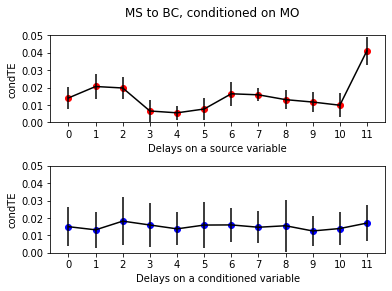

In [153]:
visualize_result(result, ('BC','MS','MO'))

<Figure size 1008x720 with 0 Axes>

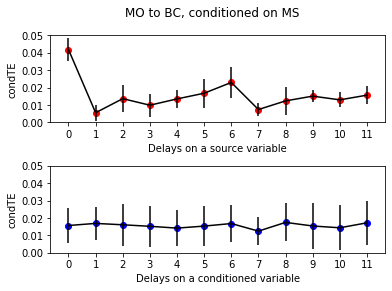

In [154]:
visualize_result(result, ('BC','MO','MS'))

<Figure size 1008x720 with 0 Axes>

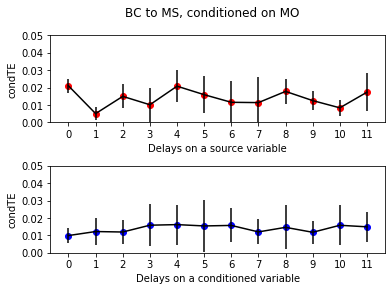

In [155]:
visualize_result(result, ('MS','BC','MO'))

<Figure size 1008x720 with 0 Axes>

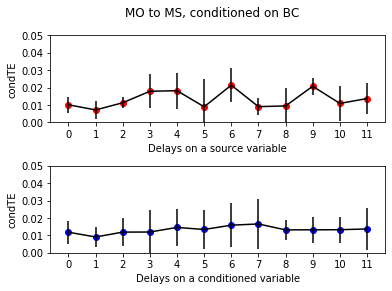

In [156]:
visualize_result(result, ('MS','MO','BC'))

<Figure size 1008x720 with 0 Axes>

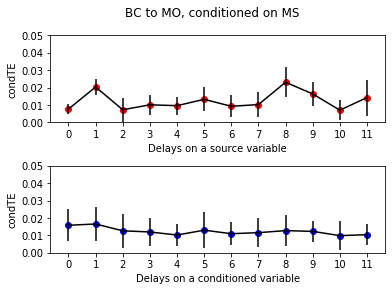

In [157]:
visualize_result(result, ('MO','BC','MS'))

<Figure size 1008x720 with 0 Axes>

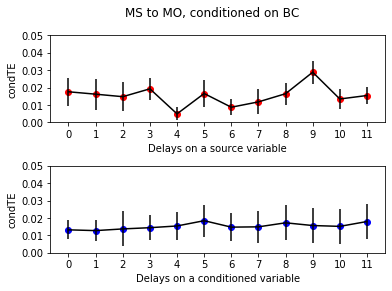

In [158]:
visualize_result(result, ('MO','MS','BC'))